In [1]:
# Data processing
# ==============================================================================
import numpy as np
import pandas as pd

# Plots
# ==============================================================================
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import plotly.express as px
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
%matplotlib inline

# Modelling and Forecasting
# ==============================================================================
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

from joblib import dump, load

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\pandas\compat\_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)
C:\Users\New\Anaconda3\lib\site-packages\dask\dataframe\utils.py:15: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
#Reading in data
# ==============================================================================
solar3=pd.read_csv('Solar 3.csv')

In [3]:
#Converting to Datetime objects
# ==============================================================================
solar3['datetime']=pd.to_datetime(solar3['datetime'], format='%Y-%m-%d %H:%M:%S')
solar3= solar3.set_index('datetime')
solar3= solar3.asfreq('H')

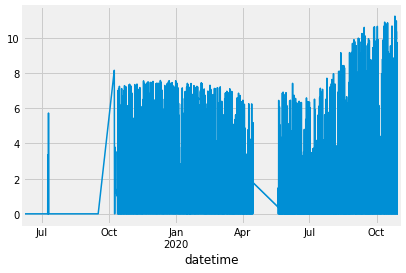

In [4]:
solar3['series_value'].plot()

In [17]:
#Split Train-Val for Solar3
# ==============================================================================
start_train='2019-10-10 00:00'
end_train='2020-04-01 00:00'
start_val='2020-06-01 01:00'
end_val='2020-08-01 00:00'
start_test='2020-08-01 01:00'

solar3train=solar3.loc[start_train:end_train, :]
solar3val=solar3.loc[start_val:end_val, :]
solar3test=solar3.loc[start_test:, :]

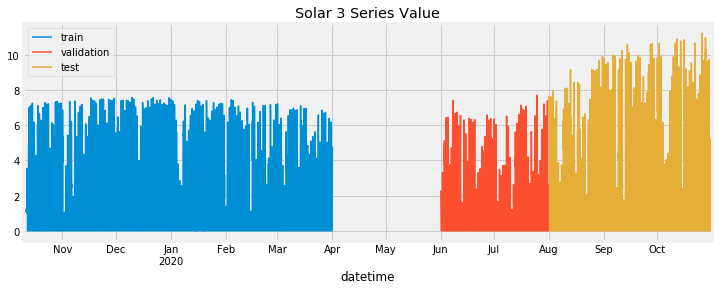

In [16]:
# Plot time series
# ==============================================================================
fig, ax = plt.subplots(figsize=(11, 4))
solar3train['series_value'].plot(ax=ax, label='train')
solar3val['series_value'].plot(ax=ax, label='validation')
solar3test['series_value'].plot(ax=ax, label='test')
ax.set_title('Solar 3 Series Value')
ax.legend();

In [18]:
# Create forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = LGBMRegressor(random_state=123),
                lags = 24
                )

forecaster

ForecasterAutoreg 
Regressor: LGBMRegressor(random_state=123) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Window size: 24 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: None 
Training index type: None 
Training index frequency: None 
Regressor parameters: {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': 123, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': 'warn', 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0} 
Creation date: 2022-09-23 18:10:56 
Last fit date: None 
Skforecast version: 0.4.3 

In [19]:
# Grid search of hyperparameters and lags
# ==============================================================================
# Regressor hyperparameters

param_grid = {
    'n_estimators': [100, 500],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1]
    }
lags_grid = [24, 48, 72, [1, 2, 3, 23, 24, 25, 71, 72, 73]]

results_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = solar3.loc[:end_val, 'series_value'],
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(solar3train)),
                        lags_grid          = lags_grid,
                        param_grid         = param_grid,
                        steps              = 36,
                        )

Number of models compared: 48


loop param_grid:   0%|                                             | 0/12 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:   8%|███                                  | 1/12 [00:00<00:09,  1.21it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  17%|██████▏                              | 2/12 [00:01<00:09,  1.01it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  25%|█████████▎                           | 3/12 [00:02<00:08,  1.04it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  33%|████████████▎                        | 4/12 [00:04<00:08,  1.11s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  42%|███████████████▍                     | 5/12 [00:05<00:07,  1.04s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  50%|██████████████████▌                  | 6/12 [00:07<00:09,  1.64s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  58%|█████████████████████▌               | 7/12 [00:08<00:07,  1.40s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  67%|████████████████████████▋            | 8/12 [00:10<00:05,  1.36s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  75%|███████████████████████████▊         | 9/12 [00:11<00:03,  1.26s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  83%|██████████████████████████████      | 10/12 [00:12<00:02,  1.30s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  92%|█████████████████████████████████   | 11/12 [00:13<00:01,  1.19s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:   0%|                                             | 0/12 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:   8%|███                                  | 1/12 [00:00<00:10,  1.00it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  17%|██████▏                              | 2/12 [00:02<00:12,  1.21s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  25%|█████████▎                           | 3/12 [00:03<00:09,  1.10s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  33%|████████████▎                        | 4/12 [00:04<00:09,  1.25s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  42%|███████████████▍                     | 5/12 [00:05<00:08,  1.16s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  50%|██████████████████▌                  | 6/12 [00:07<00:08,  1.47s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  58%|█████████████████████▌               | 7/12 [00:08<00:06,  1.27s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  67%|████████████████████████▋            | 8/12 [00:09<00:04,  1.21s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  75%|███████████████████████████▊         | 9/12 [00:10<00:03,  1.13s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  83%|██████████████████████████████      | 10/12 [00:12<00:02,  1.24s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  92%|█████████████████████████████████   | 11/12 [00:13<00:01,  1.16s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:   0%|                                             | 0/12 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:   8%|███                                  | 1/12 [00:00<00:10,  1.07it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  17%|██████▏                              | 2/12 [00:02<00:11,  1.12s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  25%|█████████▎                           | 3/12 [00:03<00:10,  1.12s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  33%|████████████▎                        | 4/12 [00:05<00:10,  1.36s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  42%|███████████████▍                     | 5/12 [00:06<00:08,  1.28s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  50%|██████████████████▌                  | 6/12 [00:08<00:09,  1.65s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  58%|█████████████████████▌               | 7/12 [00:09<00:06,  1.40s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  67%|████████████████████████▋            | 8/12 [00:10<00:05,  1.35s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  75%|███████████████████████████▊         | 9/12 [00:11<00:03,  1.27s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  83%|██████████████████████████████      | 10/12 [00:13<00:02,  1.37s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  92%|█████████████████████████████████   | 11/12 [00:14<00:01,  1.28s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:   0%|                                             | 0/12 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:   8%|███                                  | 1/12 [00:00<00:09,  1.10it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  17%|██████▏                              | 2/12 [00:02<00:10,  1.02s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  25%|█████████▎                           | 3/12 [00:02<00:08,  1.03it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  33%|████████████▎                        | 4/12 [00:04<00:08,  1.12s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  42%|███████████████▍                     | 5/12 [00:05<00:07,  1.05s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  50%|██████████████████▌                  | 6/12 [00:06<00:06,  1.15s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  58%|█████████████████████▌               | 7/12 [00:07<00:05,  1.12s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  67%|████████████████████████▋            | 8/12 [00:08<00:04,  1.11s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  75%|███████████████████████████▊         | 9/12 [00:09<00:03,  1.03s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  83%|██████████████████████████████      | 10/12 [00:10<00:02,  1.06s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  92%|█████████████████████████████████   | 11/12 [00:11<00:01,  1.01s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop lags_grid: 100%|███████████████████████████████████████| 4/4 [01:00<00:00, 15.01s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72] 
  Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500}
  Backtesting metric: 1.0301329090009135



In [20]:
# Results of grid search
# ==============================================================================
results_grid.head(10)

lags  \
25  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
30  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
13  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
18  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
37                  [1, 2, 3, 23, 24, 25, 71, 72, 73]   
42                  [1, 2, 3, 23, 24, 25, 71, 72, 73]   
20  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
15  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
44                  [1, 2, 3, 23, 24, 25, 71, 72, 73]   
6   [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   

                                               params    metric  \
25  {'learning_rate': 0.01, 'max_depth': 3, 'n_est...  1.030133   
30  {'learning_rate': 0.1, 'max_depth': 3, 'n_esti...  1.037639   
13  {'learning_rate': 0.01, 'max_depth': 3, 'n_est...  1.037783   
18  {'learning_rate': 0.1, 'max_depth': 3, 'n_esti...  1.042905   
37  {'learning_rate': 0.01, 'max_depth': 3, 'n_est...  1.098659   
42  {'learning_rate': 0.1, 'max_depth': 3, 'n_esti...  1.117917   
20  {'learning_rate': 0.1, 'max_depth': 5, 'n_esti...  1.120761   
15  {'learning_rate': 0.01, 'max_depth': 5, 'n_est...  1.132371   
44  {'learning_rate': 0.1, 'max_depth': 5, 'n_esti...  1.144541   
6   {'learning_rate': 0.1, 'max_depth': 3, 'n_esti...  1.152804   

    learning_rate  max_depth  n_estimators  
25           0.01        3.0         500.0  
30           0.10        3.0         100.0  
13           0.01        3.0         500.0  
18           0.10        3.0         100.0  
37           0.01        3.0         500.0  
42           0.10        3.0         100.0  
20           0.10        5.0         100.0  
15           0.01        5.0         500.0  
44           0.10        5.0         100.0  
6            0.10        3.0         100.0

In [21]:
# Backtesting
# ==============================================================================
metric, predictions = backtesting_forecaster(
    forecaster = forecaster,
    y          = solar3['series_value'],
    initial_train_size = len(solar3.loc[:end_val]),
    fixed_train_size   = False,
    steps      = 36,
    refit      = False,
    metric     = 'mean_squared_error',
    verbose    = False 
    )

print(f"Backtest error: {metric}")

Backtest error: 2.491155302825033


In [22]:
# Predictions
# ==============================================================================
predictions

pred
2020-08-01 01:00:00  3.836808
2020-08-01 02:00:00  4.830796
2020-08-01 03:00:00  4.673485
2020-08-01 04:00:00  4.058449
2020-08-01 05:00:00  2.350270
...                       ...
2020-10-31 19:00:00  0.095809
2020-10-31 20:00:00  0.514705
2020-10-31 21:00:00  1.510021
2020-10-31 22:00:00  2.673319
2020-10-31 23:00:00  3.536555

[2207 rows x 1 columns]

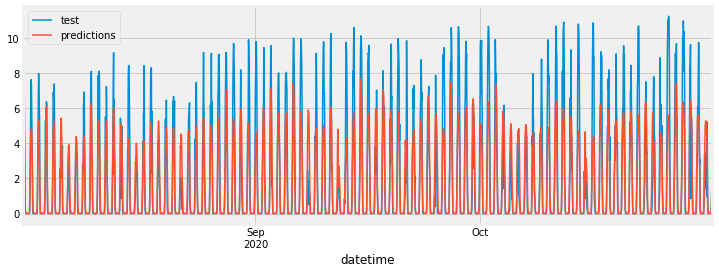

In [23]:
# Plot of predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(11, 4))
solar3test['series_value'].plot(ax=ax, label='test')
predictions['pred'].plot(ax=ax, label='predictions')
ax.legend();

In [24]:
from sklearn.metrics import mean_absolute_error

def mean_absolute_scaled_error(y_true, y_pred, y_train):
    e_t = y_true - y_pred
    scale = mean_absolute_error(y_train[1:], y_train[:-1])
    return np.mean(np.abs(e_t / scale))

In [25]:
solar3test=solar3test.dropna()
solar3train=solar3train.dropna()

In [27]:
LGBM_Mase=mean_absolute_scaled_error(solar3test.reset_index()['series_value'],predictions.reset_index()['pred'],solar3train.reset_index()['series_value'])

In [28]:
# CatBoost Forecasting
# ==============================================================================

In [29]:
# Create Catboost forecaster
# ==============================================================================
cat_forecaster = ForecasterAutoreg(
                regressor = CatBoostRegressor(random_state=123, silent=True),
                lags = 24
                )

cat_forecaster

ForecasterAutoreg 
Regressor: <catboost.core.CatBoostRegressor object at 0x000002602038A470> 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Window size: 24 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: None 
Training index type: None 
Training index frequency: None 
Regressor parameters: {'loss_function': 'RMSE', 'silent': True, 'random_state': 123} 
Creation date: 2022-09-25 01:23:49 
Last fit date: None 
Skforecast version: 0.4.3 

In [30]:
# Grid search of hyperparameters and lags
# ==============================================================================
# Regressor hyperparameters

param_grid = {
    'n_estimators': [100, 500],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1]
    }
lags_grid = [24, 48, 72, [1, 2, 3, 23, 24, 25, 71, 72, 73]]

results_grid = grid_search_forecaster(
                        forecaster         = cat_forecaster,
                        y                  = solar3.loc[:end_val, 'series_value'],
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(solar3train)),
                        lags_grid          = lags_grid,
                        param_grid         = param_grid,
                        steps              = 36,
                        )

Number of models compared: 48


loop param_grid:   0%|                                             | 0/12 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:   8%|███                                  | 1/12 [00:12<02:18, 12.61s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  17%|██████▏                              | 2/12 [00:34<02:59, 17.90s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  25%|█████████▎                           | 3/12 [01:06<03:38, 24.25s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  33%|████████████▎                        | 4/12 [01:45<04:01, 30.16s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  42%|███████████████▍                     | 5/12 [02:40<04:34, 39.25s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  50%|██████████████████▌                  | 6/12 [04:15<05:49, 58.22s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  58%|█████████████████████▌               | 7/12 [04:31<03:42, 44.53s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  67%|████████████████████████▋            | 8/12 [05:00<02:37, 39.45s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  75%|███████████████████████████▊         | 9/12 [05:34<01:52, 37.61s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  83%|██████████████████████████████      | 10/12 [06:46<01:36, 48.34s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  92%|█████████████████████████████████   | 11/12 [08:03<00:57, 57.16s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:   0%|                                             | 0/12 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:   8%|███                                  | 1/12 [00:47<08:46, 47.90s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  17%|██████▏                              | 2/12 [01:36<08:02, 48.27s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  25%|█████████▎                           | 3/12 [02:31<07:43, 51.48s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  33%|████████████▎                        | 4/12 [03:43<07:56, 59.53s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  42%|███████████████▍                     | 5/12 [05:40<09:22, 80.30s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  50%|██████████████████                  | 6/12 [11:26<17:04, 170.67s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  58%|█████████████████████               | 7/12 [12:42<11:37, 139.51s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  67%|████████████████████████            | 8/12 [14:05<08:06, 121.72s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  75%|███████████████████████████         | 9/12 [15:30<05:30, 110.14s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  83%|█████████████████████████████▏     | 10/12 [17:00<03:27, 103.80s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  92%|████████████████████████████████   | 11/12 [19:20<01:54, 114.96s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:   0%|                                             | 0/12 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:   8%|███                                 | 1/12 [01:41<18:33, 101.24s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  17%|██████                              | 2/12 [03:39<18:32, 111.24s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  25%|█████████                           | 3/12 [06:06<19:07, 127.52s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  33%|████████████                        | 4/12 [08:36<18:11, 136.47s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  42%|███████████████                     | 5/12 [12:12<19:15, 165.08s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  50%|██████████████████                  | 6/12 [20:38<28:06, 281.06s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  58%|█████████████████████               | 7/12 [23:05<19:46, 237.29s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  67%|████████████████████████            | 8/12 [25:48<14:13, 213.49s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  75%|███████████████████████████         | 9/12 [28:44<10:05, 201.71s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  83%|█████████████████████████████▏     | 10/12 [32:01<06:40, 200.49s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  92%|████████████████████████████████   | 11/12 [36:19<03:38, 218.06s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:   0%|                                             | 0/12 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:   8%|███                                 | 1/12 [02:57<32:29, 177.18s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  17%|██████                              | 2/12 [06:15<31:34, 189.50s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  25%|█████████                           | 3/12 [12:15<40:05, 267.24s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  33%|████████████                        | 4/12 [22:26<53:45, 403.21s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  42%|███████████████                     | 5/12 [29:57<49:01, 420.21s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  50%|██████████████████                  | 6/12 [40:13<48:42, 487.00s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  58%|█████████████████████               | 7/12 [42:43<31:23, 376.68s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  67%|████████████████████████            | 8/12 [45:17<20:23, 305.87s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  75%|███████████████████████████         | 9/12 [54:18<18:57, 379.29s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  83%|███████████████████████████▌     | 10/12 [1:05:00<15:20, 460.39s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  92%|██████████████████████████████▎  | 11/12 [1:15:11<08:26, 506.64s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop lags_grid: 100%|███████████████████████████████████| 4/4 [2:47:29<00:00, 2512.30s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
  Backtesting metric: 1.0185798444484444



In [31]:
# Backtesting
# ==============================================================================
metric, cat_predictions = backtesting_forecaster(
    forecaster = cat_forecaster,
    y          = solar3['series_value'],
    initial_train_size = len(solar3.loc[:end_val]),
    fixed_train_size   = False,
    steps      = 36,
    refit      = False,
    metric     = 'mean_squared_error',
    verbose    = False
    )

print(f"Backtest error: {metric}")

Backtest error: 2.5267851565005546


In [32]:
CatBoost_MASE=mean_absolute_scaled_error(solar3test.reset_index()['series_value'],cat_predictions.reset_index()['pred'],solar3train.reset_index()['series_value'])

In [36]:
# Create XGB forecaster
# ==============================================================================
XGB_forecaster = ForecasterAutoreg(
                regressor = XGBRegressor(random_state=123),
                lags = 24
                )

XGB_forecaster

ForecasterAutoreg 
Regressor: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=123,
             reg_alpha=None, reg_lambda=None, ...) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Window size: 24 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: None 
Training index type: None 

In [37]:
# Grid search of hyperparameters and lags
# ==============================================================================
# Regressor hyperparameters

param_grid = {
    'n_estimators': [100, 500],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1]
    }
lags_grid = [24, 48, 72, [1, 2, 3, 23, 24, 25, 71, 72, 73]]

results_grid = grid_search_forecaster(
                        forecaster         = XGB_forecaster,
                        y                  = solar3.loc[:end_val, 'series_value'],
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(solar3train)),
                        lags_grid          = lags_grid,
                        param_grid         = param_grid,
                        steps              = 36,
                        )

Number of models compared: 48


loop param_grid:   0%|                                             | 0/12 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:   8%|███                                  | 1/12 [00:06<01:09,  6.30s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  17%|██████▏                              | 2/12 [00:13<01:05,  6.60s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  25%|█████████▎                           | 3/12 [00:19<00:59,  6.57s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  33%|████████████▎                        | 4/12 [00:27<00:55,  6.93s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  42%|███████████████▍                     | 5/12 [00:34<00:49,  7.01s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  50%|██████████████████▌                  | 6/12 [00:44<00:48,  8.08s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  58%|█████████████████████▌               | 7/12 [00:50<00:37,  7.56s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  67%|████████████████████████▋            | 8/12 [00:57<00:29,  7.37s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  75%|███████████████████████████▊         | 9/12 [01:04<00:21,  7.17s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  83%|██████████████████████████████      | 10/12 [01:12<00:14,  7.46s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  92%|█████████████████████████████████   | 11/12 [01:19<00:07,  7.34s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:   0%|                                             | 0/12 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:   8%|███                                  | 1/12 [00:06<01:11,  6.49s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  17%|██████▏                              | 2/12 [00:14<01:11,  7.16s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  25%|█████████▎                           | 3/12 [00:20<01:02,  6.96s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  33%|████████████▎                        | 4/12 [00:29<01:01,  7.68s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  42%|███████████████▍                     | 5/12 [00:36<00:52,  7.50s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  50%|██████████████████▌                  | 6/12 [00:48<00:54,  9.08s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  58%|█████████████████████▌               | 7/12 [00:55<00:41,  8.22s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  67%|████████████████████████▋            | 8/12 [01:03<00:32,  8.03s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  75%|███████████████████████████▊         | 9/12 [01:09<00:22,  7.56s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  83%|██████████████████████████████      | 10/12 [01:18<00:16,  8.02s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  92%|█████████████████████████████████   | 11/12 [01:26<00:08,  8.00s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:   0%|                                             | 0/12 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:   8%|███                                  | 1/12 [00:07<01:19,  7.21s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  17%|██████▏                              | 2/12 [00:15<01:17,  7.76s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  25%|█████████▎                           | 3/12 [00:22<01:07,  7.45s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  33%|████████████▎                        | 4/12 [00:32<01:07,  8.41s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  42%|███████████████▍                     | 5/12 [00:40<00:57,  8.25s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  50%|██████████████████▌                  | 6/12 [00:54<01:00, 10.12s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  58%|█████████████████████▌               | 7/12 [01:00<00:45,  9.02s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  67%|████████████████████████▋            | 8/12 [01:09<00:35,  8.93s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  75%|███████████████████████████▊         | 9/12 [01:16<00:24,  8.29s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  83%|██████████████████████████████      | 10/12 [01:26<00:17,  8.78s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  92%|█████████████████████████████████   | 11/12 [01:34<00:08,  8.48s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:   0%|                                             | 0/12 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:   8%|███                                  | 1/12 [00:06<01:11,  6.47s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  17%|██████▏                              | 2/12 [00:13<01:08,  6.84s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  25%|█████████▎                           | 3/12 [00:19<00:58,  6.55s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  33%|████████████▎                        | 4/12 [00:26<00:53,  6.64s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  42%|███████████████▍                     | 5/12 [00:33<00:46,  6.63s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  50%|██████████████████▌                  | 6/12 [00:41<00:43,  7.25s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  58%|█████████████████████▌               | 7/12 [00:47<00:34,  6.90s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  67%|████████████████████████▋            | 8/12 [00:54<00:27,  6.93s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  75%|███████████████████████████▊         | 9/12 [01:01<00:20,  6.78s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  83%|██████████████████████████████      | 10/12 [01:08<00:13,  6.90s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop param_grid:  92%|█████████████████████████████████   | 11/12 [01:14<00:06,  6.80s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 4177
Number of observations used for backtesting: 5962
    Number of folds: 166
    Number of steps per fold: 36
    Last fold only includes 22 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-26 15:00:00 -- 2019-11-28 02:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-28 03:00:00 -- 2019-11-29 14:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-11-29 15:00:00 -- 2019-12-01 02:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-01 03:00:00 -- 2019-12-02 14:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2019-11-26 14:00:00
    Validation: 2019-12-02 15:00:00 -- 2


loop lags_grid: 100%|███████████████████████████████████████| 4/4 [06:10<00:00, 92.65s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72] 
  Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500}
  Backtesting metric: 1.0071262315929395



In [38]:
# Backtesting
# ==============================================================================
metric, XGB_predictions = backtesting_forecaster(
    forecaster = XGB_forecaster,
    y          = solar3['series_value'],
    initial_train_size = len(solar3.loc[:end_val]),
    fixed_train_size   = False,
    steps      = 36,
    refit      = False,
    metric     = 'mean_squared_error',
    verbose    = False
    )

print(f"Backtest error: {metric}")

Backtest error: 2.6324473108437885


In [39]:
XGB_MASE=mean_absolute_scaled_error(solar3test.reset_index()['series_value'],XGB_predictions.reset_index()['pred'],solar3train.reset_index()['series_value'])

In [40]:
#Using Prophet into LightGBM
# ==============================================================================
prophet=pd.read_csv('s3_actual_additive.csv')

In [41]:
#Converting to Datetime objects
# ==============================================================================
prophet['datetime']=pd.to_datetime(prophet['datetime'], format='%Y-%m-%d %H:%M:%S')
prophet= prophet.set_index('datetime')
prophet= prophet.asfreq('H')

In [42]:
prophettrain=prophet.loc[:end_train, :]
prophetval=prophet.loc[start_val:end_val, :]
prophettest=prophet.loc[start_test:, :]

In [43]:
prophet=prophet.dropna()

In [44]:
# Grid search of hyperparameters and lags
# ==============================================================================
# Regressor hyperparameters

param_grid = {
    'n_estimators': [100, 500],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1]
    }
lags_grid = [24, 48, 72, [1, 2, 3, 23, 24, 25, 71, 72, 73]]

results_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = prophet.loc[:end_val, 'subtraction'],
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(prophettrain)),
                        lags_grid          = lags_grid,
                        param_grid         = param_grid,
                        steps              = 36,
                        )

Number of models compared: 48


loop param_grid:   0%|                                             | 0/12 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 7211
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 20


loop param_grid:   8%|███                                  | 1/12 [00:00<00:06,  1.75it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 7211
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 20


loop param_grid:  17%|██████▏                              | 2/12 [00:01<00:07,  1.42it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 7211
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 20


loop param_grid:  25%|█████████▎                           | 3/12 [00:02<00:06,  1.47it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 7211
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 20


loop param_grid:  33%|████████████▎                        | 4/12 [00:03<00:06,  1.15it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 7211
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 20


loop param_grid:  42%|███████████████▍                     | 5/12 [00:03<00:05,  1.25it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 7211
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 20


loop param_grid:  50%|██████████████████▌                  | 6/12 [00:05<00:05,  1.03it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 7211
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 20


loop param_grid:  58%|█████████████████████▌               | 7/12 [00:05<00:04,  1.20it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 7211
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 20


loop param_grid:  67%|████████████████████████▋            | 8/12 [00:06<00:03,  1.18it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 7211
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 20


loop param_grid:  75%|███████████████████████████▊         | 9/12 [00:07<00:02,  1.22it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 7211
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 20


loop param_grid:  83%|██████████████████████████████      | 10/12 [00:08<00:01,  1.16it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 7211
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 20


loop param_grid:  92%|█████████████████████████████████   | 11/12 [00:08<00:00,  1.27it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 7211
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 20


loop param_grid:   0%|                                             | 0/12 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 7211
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 20


loop param_grid:   8%|███                                  | 1/12 [00:00<00:06,  1.59it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 7211
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 20


loop param_grid:  17%|██████▏                              | 2/12 [00:01<00:08,  1.19it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 7211
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 20


loop param_grid:  25%|█████████▎                           | 3/12 [00:02<00:06,  1.32it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 7211
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 20


loop param_grid:  33%|████████████▎                        | 4/12 [00:03<00:08,  1.00s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 7211
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 20


loop param_grid:  42%|███████████████▍                     | 5/12 [00:04<00:06,  1.10it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 7211
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 20


loop param_grid:  50%|██████████████████▌                  | 6/12 [00:06<00:07,  1.27s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 7211
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 20


loop param_grid:  58%|█████████████████████▌               | 7/12 [00:07<00:05,  1.11s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 7211
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 20


loop param_grid:  67%|████████████████████████▋            | 8/12 [00:08<00:04,  1.14s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 7211
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 20


loop param_grid:  75%|███████████████████████████▊         | 9/12 [00:09<00:02,  1.00it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 7211
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 20


loop param_grid:  83%|██████████████████████████████      | 10/12 [00:10<00:02,  1.13s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 7211
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 20


loop param_grid:  92%|█████████████████████████████████   | 11/12 [00:11<00:01,  1.05s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 7211
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 20


loop param_grid:   0%|                                             | 0/12 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 7211
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 20


loop param_grid:   8%|███                                  | 1/12 [00:00<00:07,  1.51it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 7211
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 20


loop param_grid:  17%|██████▏                              | 2/12 [00:01<00:09,  1.11it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 7211
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 20


loop param_grid:  25%|█████████▎                           | 3/12 [00:02<00:07,  1.20it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 7211
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 20


loop param_grid:  33%|████████████▎                        | 4/12 [00:04<00:10,  1.26s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 7211
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 20


loop param_grid:  42%|███████████████▍                     | 5/12 [00:05<00:08,  1.16s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 7211
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 20


loop param_grid:  50%|██████████████████▌                  | 6/12 [00:08<00:10,  1.68s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 7211
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 20


loop param_grid:  58%|█████████████████████▌               | 7/12 [00:08<00:06,  1.33s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 7211
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 20


loop param_grid:  67%|████████████████████████▋            | 8/12 [00:09<00:05,  1.25s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 7211
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 20


loop param_grid:  75%|███████████████████████████▊         | 9/12 [00:10<00:03,  1.12s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 7211
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 20


loop param_grid:  83%|██████████████████████████████      | 10/12 [00:12<00:02,  1.28s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 7211
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 20


loop param_grid:  92%|█████████████████████████████████   | 11/12 [00:13<00:01,  1.21s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 7211
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 20


loop param_grid:   0%|                                             | 0/12 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 7211
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 20


loop param_grid:   8%|███                                  | 1/12 [00:00<00:06,  1.68it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 7211
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 20


loop param_grid:  17%|██████▏                              | 2/12 [00:01<00:06,  1.45it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 7211
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 20


loop param_grid:  25%|█████████▎                           | 3/12 [00:01<00:05,  1.50it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 7211
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 20


loop param_grid:  33%|████████████▎                        | 4/12 [00:02<00:06,  1.26it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 7211
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 20


loop param_grid:  42%|███████████████▍                     | 5/12 [00:03<00:05,  1.36it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 7211
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 20


loop param_grid:  50%|██████████████████▌                  | 6/12 [00:04<00:05,  1.13it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 7211
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 20


loop param_grid:  58%|█████████████████████▌               | 7/12 [00:05<00:03,  1.31it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 7211
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 20


loop param_grid:  67%|████████████████████████▋            | 8/12 [00:06<00:03,  1.25it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 7211
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 20


loop param_grid:  75%|███████████████████████████▊         | 9/12 [00:06<00:02,  1.37it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 7211
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 20


loop param_grid:  83%|██████████████████████████████      | 10/12 [00:07<00:01,  1.22it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 7211
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 20


loop param_grid:  92%|█████████████████████████████████   | 11/12 [00:08<00:00,  1.26it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 7211
Number of observations used for backtesting: 2928
    Number of folds: 82
    Number of steps per fold: 36
    Last fold only includes 12 observations

Data partition in fold: 0
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-01 01:00:00 -- 2020-04-02 12:00:00
Data partition in fold: 1
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-02 13:00:00 -- 2020-04-04 00:00:00
Data partition in fold: 2
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-04 01:00:00 -- 2020-04-05 12:00:00
Data partition in fold: 3
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-05 13:00:00 -- 2020-04-07 00:00:00
Data partition in fold: 4
    Training:   2019-06-05 14:00:00 -- 2020-04-01 00:00:00
    Validation: 2020-04-07 01:00:00 -- 20


loop lags_grid: 100%|███████████████████████████████████████| 4/4 [00:48<00:00, 12.14s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72] 
  Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500}
  Backtesting metric: 1.0198683536845867



In [45]:
# Results of grid search
# ==============================================================================
results_grid.head(10)

lags  \
25  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
15  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
27  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
13  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
30  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
22  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
29  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
17  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
31  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
18  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   

                                               params    metric  \
25  {'learning_rate': 0.01, 'max_depth': 3, 'n_est...  1.019868   
15  {'learning_rate': 0.01, 'max_depth': 5, 'n_est...  1.028844   
27  {'learning_rate': 0.01, 'max_depth': 5, 'n_est...  1.047325   
13  {'learning_rate': 0.01, 'max_depth': 3, 'n_est...  1.078933   
30  {'learning_rate': 0.1, 'max_depth': 3, 'n_esti...  1.085195   
22  {'learning_rate': 0.1, 'max_depth': 10, 'n_est...  1.095603   
29  {'learning_rate': 0.01, 'max_depth': 10, 'n_es...  1.095826   
17  {'learning_rate': 0.01, 'max_depth': 10, 'n_es...  1.112355   
31  {'learning_rate': 0.1, 'max_depth': 3, 'n_esti...  1.144897   
18  {'learning_rate': 0.1, 'max_depth': 3, 'n_esti...  1.150041   

    learning_rate  max_depth  n_estimators  
25           0.01        3.0         500.0  
15           0.01        5.0         500.0  
27           0.01        5.0         500.0  
13           0.01        3.0         500.0  
30           0.10        3.0         100.0  
22           0.10       10.0         100.0  
29           0.01       10.0         500.0  
17           0.01       10.0         500.0  
31           0.10        3.0         500.0  
18           0.10        3.0         100.0

In [46]:
# Backtesting
# ==============================================================================
metric, prophet_predictions = backtesting_forecaster(
    forecaster = forecaster,
    y          = prophet['subtraction'],
    initial_train_size = len(prophet.loc[:end_val]),
    fixed_train_size   = False,
    steps      = 36,
    refit      = False,
    metric     = 'mean_squared_error',
    verbose    = False # Change to True to see detailed information
    )

print(f"Backtest error: {metric}")

Backtest error: 2.656489289216026


In [47]:
# Predictions
# ==============================================================================
prophet_predictions

pred
2020-08-01 01:00:00  1.897192
2020-08-01 02:00:00  2.385807
2020-08-01 03:00:00  2.516662
2020-08-01 04:00:00  2.594299
2020-08-01 05:00:00  1.957281
...                       ...
2020-10-31 19:00:00  1.073630
2020-10-31 20:00:00  1.359037
2020-10-31 21:00:00  2.082362
2020-10-31 22:00:00  2.464092
2020-10-31 23:00:00  2.605458

[2207 rows x 1 columns]

In [48]:
prophet_predictions_final=prophet_predictions.reset_index()['pred']+prophet.loc[start_test:, :].reset_index()['additive_terms']

In [49]:
prophettest=prophettest.dropna()
prophettrain=prophettrain.dropna()

In [50]:
LightGBM_Prophet_MASE=mean_absolute_scaled_error(prophettest.reset_index()['subtraction'],prophet_predictions_final,prophettrain.reset_index()['subtraction'])

In [51]:
LightGBM_Prophet_MASE

2.9558872967709315

In [52]:
LGBM_Mase

1.4164768335928706

In [53]:
CatBoost_MASE

1.4311642662415172

In [54]:
XGB_MASE

1.4497613384012855